## Cordiccart2pol Testbench


This notebook is to test the implementation of a CORDIC running on the programmable logic. The CORDIC is used to convert cartesian to polar coordinates. The output is compared with a Python calculation of the coordinate transform. It takes in x and y and gives out r and theta where r is the radius and theta is the angle.

In [22]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt

NUM_SAMPLES = 50

In [23]:
overlay=Overlay("./cordiccart2pol.bit") #Change name of bitstream as required
cordiccart2pol = overlay.cordiccart2pol_0

In [25]:
r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)

In [35]:
for i in range(NUM_SAMPLES):
    #Generating random inputs
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    
    #Computing golden output
    cn=complex(x,y)
    cn=cmath.polar(cn)
    
    #Converting input to bytes to be sent to FPGA
    x=(struct.unpack('<I', struct.pack('<f', x))[0])
    y=(struct.unpack('<I', struct.pack('<f', y))[0])
    
    #Writing values to the FPGA
    cordiccart2pol.write(0x10,x)                            
    cordiccart2pol.write(0x18,y)                            
    
    #Starting and stopping the IP (Don't change this)
    cordiccart2pol.write(0x00,1)
    cordiccart2pol.write(0x00,0)
    
    #Reading from IP
    r=cordiccart2pol.read(0x20)                         
    #r=r[2:]
    theta=cordiccart2pol.read(0x30)                    
    #theta=theta[2:]
    
    #Converting to float
    #if r!=0:
       # r=struct.unpack('>f', binascii.unhexlify(r))
       # r=r[0]
   # if theta!=0:
       # theta=struct.unpack('>f', binascii.unhexlify(theta))
       # theta=theta[0]
    r=float(r)
    theta=float(theta)
    #Comparing with golden output    
    r_error[i]="{0:.6f}".format(abs(r-cn[0]))
    theta_error[i]="{0:.6f}".format(abs(theta-cn[1]))

## Verifying Functionality

In [36]:
sum_sq_r=0
sum_sq_theta=0
for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse<0.001 and theta_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Radius RMSE:  0.8381927809983095 Theta RMSE: 1.811355048593312
FAIL


## Displaying Errors

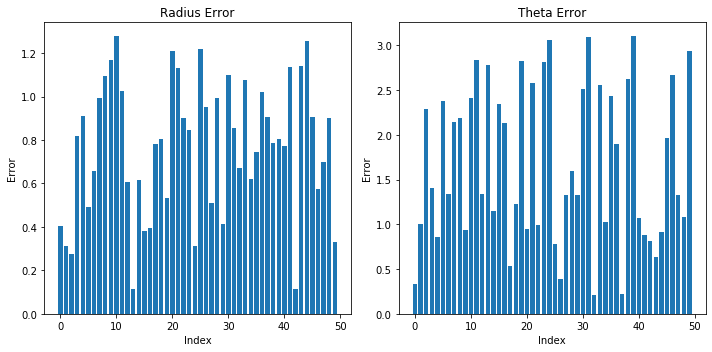

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

In [24]:
cordiccart2pol.register_map

RegisterMap {
  x = Register(x=write-only),
  y = Register(y=write-only),
  r = Register(r=0),
  r_ctrl = Register(r_ap_vld=0, RESERVED=0),
  theta = Register(theta=0),
  theta_ctrl = Register(theta_ap_vld=0, RESERVED=0)
}